In [58]:
# In this notebook, we show positive training and testing returns using RL agent. 

In [69]:

# importing library
import numpy as np
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3 import PPO
import optuna
import gym
from torch import nn as nn
import joblib
import gym_anytrading
import yfinance as yf
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from matplotlib import pyplot as plt
import finta as TA #technical indicators library imported..
from gym_anytrading.envs import StocksEnv
from gym import Env
from gym.spaces import Discrete, Box
from gym import spaces
from gym.utils import seeding
import pandas as pd
from stable_baselines.common.env_checker import check_env
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import time
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy



In [70]:
# Class for trading
# This is the trading training environment
class TradingEnv(gym.Env):

    metadata = { 'render.modes': [ 'human' ] }

    def __init__(self, df, loss_constraint=0.4):

        super(TradingEnv, self).__init__()

        self.df = df
        #print(df.shape)
        self.metrics = []
        self.step_index = 0
        
        # Position size from 1 to 10
        self._position = 0
        # Initial Action 
        self._action = "NONE"
        self._reward = 0
        self._cumulative_reward = 0
        self._max_cumulative_reward = 0
        self.loss_constraint = loss_constraint
        
        self.action_space = spaces.Discrete(20)
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float16)

    def step(self, action):
        done=False
        self._take_action(action)
        self._reward = self.compute_reward()
        reward = self._reward
        self._cumulative_reward = self._cumulative_reward + reward
        self.step_index +=1
        
        # keeping track of maximum cumulative return
        if self._cumulative_reward > self._max_cumulative_reward:
            self._max_cumulative_reward = self._cumulative_reward

        # if current accumulated reward is less than max reward achieved in the past by more than 40%
        # you have lost 40% of accrued capital, it's time to stop-out
        if (self._cumulative_reward - self._max_cumulative_reward) < (self.loss_constraint*-1):
            #print('Agent losses')
            #reward = 
            #self._cumulative_reward = self._cumulative_reward + reward
            done=True
        
        info = self._compute_step_info(reward)
        self.metrics.append(info)

        if self.step_index == (self.df.shape[0]-1):
            done = True
        
        if done:
            self.metrics = []
            self.step_index = 0
                #print("Agent Gets Positive Returns!!!")
        obs = self._next_observation()
        
        return obs, reward, done, info

    def reset(self):
        #self.df=df
        self.metrics = []
        self.step_index = 0
        self._reward = 0
        self._cumulative_reward = 0
        self._max_cumulative_reward = 0
        
        # initial position is zero contracts
        self._position = 0
        # Initial Action 
        self._action = "NONE"
        #print(self.df.iloc[0,1])

        return self._next_observation()
    
    def _compute_step_info(self, reward):
        return {
            'Date': self.df.index[self.step_index],
            'Action': self._direction,
            'Contracts': np.abs(self._position),
            'UnLevered Return': np.round(reward*100/np.abs(self._position),3),
            'Levered Return': np.round(reward*100,3),
            'Cumulative Levered Return': np.round(self._cumulative_reward*100,3),
            'Max Cumulative Levered Return': np.round(self._max_cumulative_reward*100,3)
            
           
        }

    def _next_observation(self):
        
        #print(df.shape)
        obs = np.array([
            self.df.iloc[self.step_index, 1],
            #self.df.iloc[self.step_index, 2],
        ])
        return obs

    def _take_action(self, action):
        action = action + 1
        if action <=10:
            self._position = action
            self._direction = "BUY"
        
        else:
            self._position = 10-action
            self._direction = "SELL"
        
    def compute_reward(self):
        
        reward = self._position * self.df.iloc[self.step_index, 0]
        

        return reward
    
    def render(self, mode='human'):
        pass
    
    def close(self):
        pass

,Dependent,Feature1
Date,,
2021-11-08,0.000000,0.000000
2021-11-09,-0.003311,0.000000
2021-11-10,-0.008077,-0.003311
2021-11-11,0.000324,-0.008077
2021-11-12,0.007518,0.000324
2021-11-15,0.000342,0.007518
2021-11-16,0.003950,0.000342
2021-11-17,-0.002432,0.003950
2021-11-18,0.003391,-0.002432


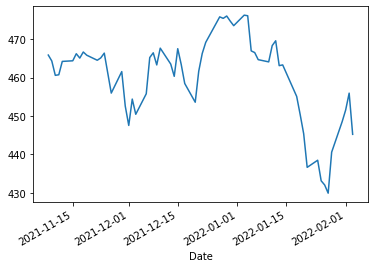

In [71]:
#load df with return as the dependent variable and lagged returns as feature
df = yf.download('SPY', start='2021-11-06', end='2022-02-06', progress=False, index_col=0)
df.drop("Close", axis=1, inplace=True)
df.rename(columns = {'Adj Close':'Close'}, inplace = True)
df.head()
df.fillna(0,inplace=True)
df.drop(df.tail(1).index,inplace=True) # drop last n rows
df.head(5)
df.drop("Open", axis=1, inplace=True)
df.drop("High", axis=1, inplace=True)
df.drop("Low", axis=1, inplace=True)
df.drop("Volume", axis=1, inplace=True)
df["Close"].plot()
df["Dependent"]=df["Close"].pct_change(1) # 1 for ONE DAY lookback
df['Dependent'] = np.log(1 + df.Dependent)
df['Feature1']=df['Dependent'].shift(1)

df.drop("Close", axis=1, inplace=True)

df.fillna(0,inplace=True)

df.head(10)



In [81]:
# create multiple environments

def make_env(rank, df):
    #"""
    #Utility function for multiprocessed env.

    #:param num_env: (int) the number of environments you wish to have in subprocesses
    #:param rank: (int) index of the subprocess
    #"""
    #print("what up out")
    def _init():
        env = TradingEnv(df=df, loss_constraint=0.4)
        
        return env
    
    return _init
num_cpu = 5
env = SubprocVecEnv([make_env(i, df) for i in range(num_cpu)])
env = VecNormalize(env, norm_obs=True, norm_reward=True)

print(env.reset())

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [82]:
# run model. 
#best_trial_parameters_model = PPO('MlpPolicy', env, verbose=0, gamma=0.99, learning_rate=0.0006723344399829697, batch_size=64, seed=100)
best_trial_parameters_model = PPO('MlpPolicy', env, verbose=0, gamma=0.995, learning_rate=0.014016620989668828, batch_size=512, seed=100)

best_trial_parameters_model.learn(50000)


In [83]:
# create environment

env = TradingEnv(df=df, loss_constraint=0.4)
env_maker = lambda: env
env = DummyVecEnv([env_maker])
env = VecNormalize(env, norm_obs=True, norm_reward=True)
env.save("vec_normalize.pkl")


In [84]:
# check model returns
rewards = []
n_episodes, reward_sum = 0, 0.0
cumulative_returns =pd.DataFrame(columns=['Date', 'Cumulative Leveraged Return'])


obs = env.reset()

while n_episodes < 1:
    
    action, _ = best_trial_parameters_model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    df2 = pd.DataFrame({'Date': [info[0]["Date"]],
                    'Cumulative Leveraged Return' : [info[0]["Cumulative Levered Return"]]})


    cumulative_returns = pd.concat([cumulative_returns, df2], ignore_index = True, axis = 0)

 
    print(info)
    
    if done:
        rewards = (info[0]["Cumulative Levered Return"])
        n_episodes += 1
        obs = env.reset()


env.close()
last_reward = rewards
print("Total Cumulative Levered Return (%): ",last_reward)
cumulative_returns['Date'] = pd.to_datetime(cumulative_returns['Date'])
cumulative_returns.set_index('Date', inplace=True)


[{'Date': Timestamp('2022-02-08 00:00:00'), 'Action': 'SELL', 'Contracts': 6, 'UnLevered Return': -0.0, 'Levered Return': -0.0, 'Cumulative Levered Return': 0.0, 'Max Cumulative Levered Return': 0}]
[{'Date': Timestamp('2022-02-09 00:00:00'), 'Action': 'SELL', 'Contracts': 6, 'UnLevered Return': -0.819, 'Levered Return': -4.917, 'Cumulative Levered Return': -4.917, 'Max Cumulative Levered Return': 0}]
[{'Date': Timestamp('2022-02-10 00:00:00'), 'Action': 'BUY', 'Contracts': 3, 'UnLevered Return': 1.453, 'Levered Return': 4.359, 'Cumulative Levered Return': -0.558, 'Max Cumulative Levered Return': 0}]
[{'Date': Timestamp('2022-02-11 00:00:00'), 'Action': 'BUY', 'Contracts': 3, 'UnLevered Return': -1.813, 'Levered Return': -5.439, 'Cumulative Levered Return': -5.996, 'Max Cumulative Levered Return': 0}]
[{'Date': Timestamp('2022-02-14 00:00:00'), 'Action': 'SELL', 'Contracts': 6, 'UnLevered Return': 1.992, 'Levered Return': 11.949, 'Cumulative Levered Return': 5.953, 'Max Cumulative Leve

<AxesSubplot:title={'center':'Train: Cumulative Levered SPY Returns'}, xlabel='Date'>

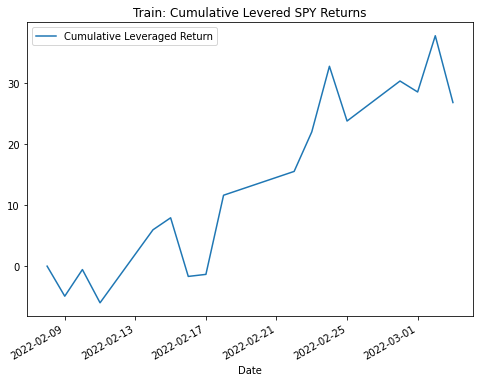

In [85]:
cumulative_returns.plot(title="Train: Cumulative Levered SPY Returns", figsize=(8,6))

[[0.]]


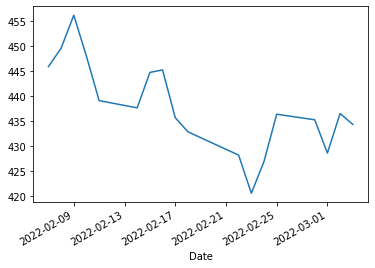

In [86]:
#Load test data 

df = yf.download('SPY', start='2022-02-07', end='2022-03-06', progress=False)
df.drop("Close", axis=1, inplace=True)
df.rename(columns = {'Adj Close':'Close'}, inplace = True)
df.head()
df.fillna(0,inplace=True)
df.drop(df.tail(1).index,inplace=True) # drop last n rows
df.head(5)
df.drop("Open", axis=1, inplace=True)
df.drop("High", axis=1, inplace=True)
df.drop("Low", axis=1, inplace=True)
df.drop("Volume", axis=1, inplace=True)
df["Close"].plot()
df["Dependent"]=df["Close"].pct_change(1) # 1 for ONE DAY lookback
df['Dependent'] = np.log(1 + df.Dependent)
df['Feature1']=df['Dependent'].shift(1)
df.drop("Close", axis=1, inplace=True)
df.fillna(0,inplace=True)
df.head(10)

# create environment
env = TradingEnv(df=df, loss_constraint=0.4)
env_maker = lambda: env
env = DummyVecEnv([env_maker])
env = VecNormalize.load("vec_normalize.pkl", env)
env.norm_obs =True
# reward normalization is not needed at test time
env.norm_reward = True
obs = env.reset()
print(obs)

Total Cumulative Levered Return (%):  26.784


<AxesSubplot:title={'center':'Test: Cumulative Levered Returns'}, xlabel='Date'>

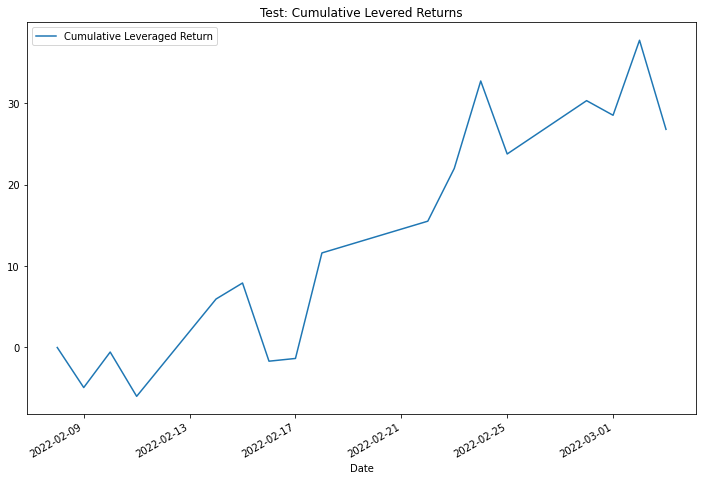

In [87]:

rewards = []
cumulative_returns =pd.DataFrame(columns=['Date', 'Cumulative Leveraged Return'])
n_episodes, reward_sum = 0, 0.0

obs = env.reset()

while n_episodes < 1:
    
    action, _ = best_trial_parameters_model.predict(obs, deterministic=True)
    
    obs, reward, done, info = env.step(action)
    newRow={'Date':info[0]["Cumulative Levered Return"],'Cumulative Leveraged Return':info[0]["Cumulative Levered Return"]}
    df2 = pd.DataFrame({'Date': [info[0]["Date"]],
                    'Cumulative Leveraged Return' : [info[0]["Cumulative Levered Return"]]})

    cumulative_returns = pd.concat([cumulative_returns, df2], ignore_index = True, axis = 0)

    #print(info)
    
    if done:
        rewards = (info[0]["Cumulative Levered Return"])
        n_episodes += 1
        obs = env.reset()



env.close()
last_reward = rewards
print("Total Cumulative Levered Return (%): ",last_reward)
cumulative_returns['Date'] = pd.to_datetime(cumulative_returns['Date'])
cumulative_returns.set_index('Date', inplace=True)
cumulative_returns.head(5)
cumulative_returns.plot(title="Test: Cumulative Levered Returns", figsize=(12,8))